# Introduction To Sequential Data Modeling
Author/Perpetrator: Carlo Graziani, including materials on LLMs by Varuni Sastri, and discussion/editorial work by Taylor Childers, Archit Vasan, Bethany Lusch, and Venkat Vishwanath (Argonne)

Word embedding visualizations adapted from Kevin Gimpel (Toyota Technological Institute at Chicago) [Visualizing BERT](https://home.ttic.edu/~kgimpel/viz-bert/viz-bert.html).

Some inspiration from the blog post ["The Illustrated Transformer"](https://jalammar.github.io/illustrated-transformer/) by Jay Alammar, highly recommended reading before next week's deeper dive into Transformer tech by Archit Vasan.  Another useful resource is [this ALCF tutorial](https://github.com/argonne-lcf/llm-workshop/blob/main/tutorials/01-llm-101/LLMs101.ipynb).

Before you begin, make sure that you have your environment set up and your repo refreshed, as described in previous lessons, and reviewed in the accompanying 'Readme.md' file. Make sure that you select the kernel 'datascience/conda-2023-01-10' at the top-left of the Jupyter notebook.

## Modeling Sequential Data

The modern terminology for the analysis of sequential data is "large language modeling" (LLM). This usage comes from Natural Language Processing (NLP), and is perhaps unfortunate---especially from the perspective of "AI For Science," because, as I hope to clarify shortly, this kind of modeling is more generally useful than just for NLP.

This session is dedicated to setting out the basics of sequential data modeling, and introducing (and, where possible motivating) a few key elements required for DL approaches to such modeling---principally transformers.

## A Basic LLM Pipeline: Text Prediction

Let's download and run a model from the HuggingFace model hub, to start getting a feeling for one very popular LLM activity: text prediction.

In [1]:
# Administrivia: modify this notebook so output text wraps.
from IPython.display import HTML, display
def set_css():
  display(HTML('''
  <style>
    pre {
      white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# Set various proxies to download models and data
#!export HTTP_PROXY="http://proxy-01.pub.alcf.anl.gov:3128"
#!export HTTPS_PROXY="http://proxy-01.pub.alcf.anl.gov:3128"
#!export http_proxy="http://proxy-01.pub.alcf.anl.gov:3128"
#!export https_proxy="http://proxy-01.pub.alcf.anl.gov:3128"
#!export ftp_proxy="http://proxy-01.pub.alcf.anl.gov:3128" 

In [2]:
%pip install transformers

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In what follows, we will ask an LLM based on the gpt2 model to complete the phrase "I'm late because"

In [3]:
from transformers import pipeline

# In this framework, setting  up a "pipeline" involves selecting a (pre-trained) model,
# and a task---in this case, text generation 
generator = pipeline("text-generation", model='gpt2')

prompt = "I'm late because"

# We request 5 completions of the prompt, of length 25 words
res = generator(prompt, max_length=50, num_return_sequences=1)

# What did we get?
for each in res:
    print(each['generated_text'])
    print('******************"')

2024-03-03 21:55:37.721769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/soft/datascience/conda/2023-01-10/mconda3/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "
/soft/datascience/conda/2023-01-10/mconda3/lib/python3.10/site-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://hugg

I'm late because a friend sent me an update on my next game! :) Here it is in the mail. I have been stuck, since I'm from the past, in my first game in this list, when I ran out and the one
******************"


Huh. These seem pretty random.  What happens if we predict a single sentence, but extend its length?

In [4]:
res = generator(prompt, max_length=100, num_return_sequences=1)
print(res[0]['generated_text'])
print('******************"')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


I'm late because it happened and I'm in the business of running my own business, and the system just isn't working for me. It's so frustrating when someone is just starting a new business and they need some things changed, I need to make sure they're going to have a great time working in that company again. I am not a professional entrepreneur in my own right."

He added: "If this doesn't work for him, he's making the mistake of thinking I am
******************"


There are some notable features here:

1. Each sentence is different from the previous one. 
2. The sentences seem fairly disjointed, and go down weird rabbit holes after (or sometimes during) the first sentence.  
3. The sentences always, or almost always, end in mid-sentence.  

What explains this behavior?

The answer to (1) is that this kind of text prediction (like ChatGPT's) is _generative_.  The text prompt is used to contruct a probability distribution over possible completions, and each generated sentence is a _sample_ from that distribution.

The answer to (2) is: LLMs split up sentences into words or word fragments, called _tokens_. The way the samples are drawn is sequentially, one token at a time. Suppose the $k$-th token is denoted by the symbol $t_k$ ($t_k$ could be a word, a punctuation mark, a space, etc.). At stage $N$, the $N$-th token is drawn randomly from the distribution
$$
\mathrm{Prob}(t_N | \mathrm{prompt}, t_1, t_2,\ldots,t_{N-1}),
$$
at stage $N+1$ the random draw is from
$$
\mathrm{Prob}(t_{N+1} | \mathrm{prompt}, t_1, t_2,\ldots,t_{N-1},t_N),
$$
and so on.

(If you are unfamiliar with this probability notation, know that an expression such as $\mathrm{Prob}(X)$ should be read as "the probability of occurrence of event $X$", while the expression $\mathrm{Prob}(X|Y)$ should be read as "the probability of occurrence of the event $X$ _given_ that event $Y$ has been observed." This is called a _conditional probability_, and we often say "Probability of $X$ conditioned on $Y$" for $\mathrm{Prob}(X|Y)$.  The observation of $Y$ changes the probability distribution governing the occurrence of $X$.  Here, the occurrence of the prompt, and of the first $N-1$ tokens, affects the probability distribution governing the $N$-th token $t_N$.)

It follows from this fact that the sentences start growing apart at the first token $t_1$, and, depending on the model (in this case, gpt-2), are usually more strongly influenced by recent tokens than by older ones, so that $t_{90}$ is more strongly conditioned by it's immediate predecessors $t_{89}$, $t_{88}$, and $t_{87}$ than it is by the prompt, or by $t_1$, $t_2$, or $t_3$. We would say that this model's _attention_---it's ability to maintain context over sentences and paragraphs---is quite limited.

The answer to (3) is also related to the generation mechanism.  With this style of generation, it is not possible to require that the text create exactly 100-token complete sentences. The best that one could do is to run the code so as to stop after the first (or second, or third) "End of Sentence" (EOS) token.


  ## Where Do Deep Learning Model Architecture Choices Come From?

  From the model development view, the elements of a DL architecture are usually the result of _a lot_ of trial-and-error by researchers.  However, at a deeper level, those choices are dictated by the nature of the data itself: some strategies that are successful for some types of data are nearly pointless for other types.

  For example, last week Corey Adams lectured on the application of convolutional nets---network architectures based on local convolutional kernels---to image analysis. ConvNets were a remarkable discovery in the field, which arose through the desire to exploit _local 2-D spatial structure_ in images---edges, gradients, contrasts, large coherent features, small-scale details, and so on.  Convolutional kernels, together with pooling (and some other art) turn out to be exceptionally well-adapted to discovering such structure.

  On the other hand, convolutions are not as useful if the data does not have that sort of spatial structure. It would be sort of senseless to reach for convnets to model, say, seasonal effects on product sales data across different manufacturing categories, or natural language sequences (although this has been tried).

  So it makes sense to think about the nature of data when approaching this field. Generally speaking, there are two broad categories of data types that have dominated DL practice: vector data, and sequential data.  This course so far has trafficked in vector data, but with LLMs, we move into the domain of sequential data.

  What distinguishes these two data types?

### **Vector Data:** 

Fixed-length lists of real numbers, that can be visualized as living in a high-dimensional space, one dimension per list element.

### Example: **Image Data**

<p float="center">
<figure>

  <img src="Figures/CIFAR-10.png" width="500" /> 
  
 </figure>
 
</p>

  **Typical queries and decisions:**
  
* Image classification
* Inpainting---fill in blank regions
* Segmentation---Identify elements in an image, e.g. cars, people, clouds...

### Example: **Data from simulations**

<p float="center">
<figure>

  <img src="Figures/Simulations.png" width="800" /> 
  

 </figure>
 
</p>

  **Typical queries and decisions:**

* Manifold finding/data reduction, i.e. how many dimensions are _really_ required to describe the data (this is basically what autoencoders do);
* Emulation---train on simulation data, learn to produce similar output, or output at simulation settings not yet attempted, at much lower cost than the original simulators
* Forecasting of weather, economics, pollution...

### **Sequential Data:** 

_Sequences_ are variable-length lists, not necessarily real-valued, possibly containing gaps or requiring completion

### Example: **Text Documents**

<p float="center">
<figure>

  <img src="Figures/Lorem.png" width="500" /> 
  
 </figure>
 
</p>

**Typical queries and decisions:**

* Translation
* Spell checking and correction
* Text prediction and generation
* Sentiment analysis

### Example: **Genetic Sequences**

<p float="center">
<figure>

  <img src="Figures/RNA-codons.svg.png" width="500" /> 
  
 </figure>
 
</p>

**Typical queries and decisions:**

* Prediction of likely variants/mutations from DNA variability
* Realistic DNA sequence synthesis
* Predicting gene expression

### Example: **Protein Chains**

<p float="center">
<figure>

  <img src="Figures/Protein-Structure-06.png" width="500" /> 
  
 </figure>
 
</p>

**Typical queries and decisions:**

* Predict folding structure
* Predict chemical/binding properties



Other examples of scientifically important  types of sequential data include chemical compounds (sequences of atoms) and weather states (sequences of spatially-resolved temperatures, pressures, humidities, etc.). 

It should be clear from the above that sequential data is much richer and more highly-structured, in general, than vector data.


Let's take a break.  In the meantime, go back to the LLM pipeline that we built at the beginning, and try seeing what kind of text prediction result you can obtain through "prompt engineering": try making longer, or more constraining prompts, and see if you can get more sensible results from the model.

## Elements of DL Sequence Modeling

In 2017, the paper [Attention is All You Need](https://arxiv.org/abs/1706.03762) (Vaswani et al.) introduced the modern _transformer architecture_. Transformers were game-changers in the subject of sequential data modeling, but in important respects they built upon elements that were already in use in existing sequential data architectures, such as recurrent neural networks (RNNs), which they displaced.

Let's look at two of those key elements that are needed by modern sequential models (AKA "LLMs"): tokenization, and word embedding. The third key element---attention---will be covered next week.

### Tokenization

Recall that unlike vector data, sequential data can have values that are essentially arbitrary---integers, real numbers, natural language words, DNA codons, and so on.  LLMs are trained and used in a manner that is largely agnostic of the data type.  This is possible because in a step preliminary to training, LLMs convert the data to _tokens_. Tokens are elements of a finite, discrete set---a _vocabulary_, with a certain fixed _vocabulary size_.  In the case of English natural language, the vocabulary may be made up of whole words, plus punctuation, spaces, etc. with a vocabulary size approaching 500,000; or it may be made up of sub-words, or word stems, or from other clever coding schemes, with reduced vocabulary size---as low as 30,000.

There is clearly a tension represented by tokenization choice: On the one hand, there are great benefits to reducing the vocabulary size, because this can lead to substantial reductions in the number of parameters required by an LLM.  On the other hand, the actual distribution of sequence elements is more likely to be exposed to the model by more complex tokenizations, with larger vocabulary sizes.

For example, take a phrase such as "The chef added salt to the soup, because it required seasoning." The LLM needs to be able to parse such a sentence and discern, for example, that the article "it" refers to "the soup", and not to "the chef" or "salt" (how it does this is the subject of Attention, discussed next week).  It should be clear that such relationship are easier to tease out from a word tokenization ("The", "chef", "added"...) than from, say, a character-by-character tokenization ("t", "h", "e", "c"...). On the other hand, a character-by-character tokenization has a much smaller vocabulary size ($\le 40$ including punctuation, spaces, etc.), whereas an English word-based vocabulary would have a vocabulary of about 500,000 (although the majority of these would be rarely-used words).

Let's look at some tokenization examples:

In [5]:
from transformers import AutoTokenizer

# A utility function to tokenize a sequence and print out some information about it.

def tokenization_summary(tokenizer, sequence):

    # get the vocabulary
    vocab = tokenizer.vocab
    # Number of entries to print
    n = 10

    # Print subset of the vocabulary
    print("Subset of tokenizer.vocab:")
    for i, (token, index) in enumerate(tokenizer.vocab.items()):
        print(f"{token}: {index}")
        if i >= n - 1:
            break

    print("Vocab size of the tokenizer = ", len(vocab))
    print("------------------------------------------")

    # .tokenize chunks the existing sequence into different tokens based on the rules and vocab of the tokenizer.
    tokens = tokenizer.tokenize(sequence)
    print("Tokens : ", tokens)
    print("------------------------------------------")

    # .convert_tokens_to_ids or .encode or .tokenize converts the tokens to their corresponding numerical representation.
    #  .convert_tokens_to_ids has a 1-1 mapping between tokens and numerical representation
    # ids = tokenizer.convert_tokens_to_ids(tokens)
    # print("encoded Ids: ", ids)

    # .encode also adds additional information like Start of sequence tokens and End of sequene
    print("tokenized sequence : ", tokenizer.encode(sequence))

    # .tokenizer has additional information about attention_mask.
    # encode = tokenizer(sequence)
    # print("Encode sequence : ", encode)
    # print("------------------------------------------")

    # .decode decodes the ids to raw text
    ids = tokenizer.convert_tokens_to_ids(tokens)
    decode = tokenizer.decode(ids)
    print("Decode sequence : ", decode)


tokenizer_1  =  AutoTokenizer.from_pretrained("gpt2") # GPT-2 uses "Byte-Pair Encoding (BPE)"

sequence = "Counselor, please adjust your Zoom filter to appear as a human, rather than as a cat"

tokenization_summary(tokenizer_1, sequence)


Subset of tokenizer.vocab:
steamapps: 31881
ADD: 29266
asures: 13846
Ġseventeen: 38741
people: 15332
itle: 2578
Ġpropri: 15159
Attempt: 37177
Ġhairy: 43873
Ġsucceeds: 31137
Vocab size of the tokenizer =  50257
------------------------------------------
Tokens :  ['Coun', 'sel', 'or', ',', 'Ġplease', 'Ġadjust', 'Ġyour', 'ĠZoom', 'Ġfilter', 'Ġto', 'Ġappear', 'Ġas', 'Ġa', 'Ġhuman', ',', 'Ġrather', 'Ġthan', 'Ġas', 'Ġa', 'Ġcat']
------------------------------------------
tokenized sequence :  [31053, 741, 273, 11, 3387, 4532, 534, 40305, 8106, 284, 1656, 355, 257, 1692, 11, 2138, 621, 355, 257, 3797]
Decode sequence :  Counselor, please adjust your Zoom filter to appear as a human, rather than as a cat


GPT-2 uses a so-called "Byte-pair encoding" (BPE), which can break up long words into  subwords (e.g. "Coun" "sel "lor"). This allows for rare words (the majority of English vocabulary words) to be encoded in a smaller vocabulary (in this case, 50257 token IDs). This tokenization also incorporates initial whitespace before a word into the word for efficiency, so a word will be encoded differently whether it is at the beginning of the sentence (without space) or not. This is the reason for those odd-looking "Ġ" characters in the vocabulary.

For a description of how BPE works, see [this article](https://huggingface.co/learn/nlp-course/en/chapter6/5).

(Python tip: try typing "help(tokenizer_1)" for more information on what it's doing and how to use it).

Let's look at a different tokenizer now:

In [6]:
tokenizer_2  =  AutoTokenizer.from_pretrained("bert-base-cased") # BERT uses WordPiece encoding

tokenization_summary(tokenizer_2, sequence)


Subset of tokenizer.vocab:
mimic: 27180
net: 5795
coats: 19582
guitars: 7789
Otis: 20579
##hmann: 28111
##elles: 18840
tuned: 17169
Zen: 18933
People: 2563
Vocab size of the tokenizer =  28996
------------------------------------------
Tokens :  ['Counsel', '##or', ',', 'please', 'adjust', 'your', 'Zoo', '##m', 'filter', 'to', 'appear', 'as', 'a', 'human', ',', 'rather', 'than', 'as', 'a', 'cat']
------------------------------------------
tokenized sequence :  [101, 18645, 1766, 117, 4268, 14878, 1240, 13899, 1306, 12123, 1106, 2845, 1112, 170, 1769, 117, 1897, 1190, 1112, 170, 5855, 102]
Decode sequence :  Counselor, please adjust your Zoom filter to appear as a human, rather than as a cat


This model (part of the BERT family) uses WordPiece encoding.  This is another clever strategy (described [here](https://huggingface.co/learn/nlp-course/en/chapter6/6)) that reduces the vocabulary size to 28996, by starting with a character-level encoding, then training on a text corpus to find ways to efficiently merge some of these preliminary tokens into others representing longer strings of frequent occurrence.  Note that "Counsel" occurs frequently enough to rate its own token, and the algorithm builds "counselor" out of "counsel"+"or" (actually, "##or", where the "##" is a tag indicating that the token is a word piece). Similarly for "Zoom"="Zoo" + "#m".

Note that one could obtain a simpler tokenizer by using elementary Python 'string' operations to split sentences on words, punctuation, and the like, obtaining _very_ large vocabulary sizes, but not requiring advance training on corpuses of text as WordPiece and BPE do. In NLP, however, such strategies are considered naive, because very large vocabulary sizes produce cripplingly large LLM parameter sizes.  It is better to train a tokenizer on actual data.

Note also: there is, to this day, no approach to judging what is an _optimal_ tokenization---one that best preserves distributional information contained in the sequence without an exploding vocabulary size.

### Token Embedding

The strategy of choice for learning language structure from tokenized text is to find a clever way to map each token into a moderate-dimension vector space, adjusting the mapping so that 

1. Similar, or associated tokens take up residence nearby each other, and
2. Different regions of the space correspond to different position in the sequence.

Such a mapping from token ID to a point in a vector space is called a _token embedding_. The dimension of the vector space is often high (e.g. 1024-dimensional), but much smaller than the vocabulary size (30,000--500,000). The choice of this dimension is made based on a compromise between expressiveness and computational cost. Various approaches have been attempted for generating such embeddings, including static algorithms that operate on a corpus of tokenized data as preprocessors for NLP tasks.  Transformers, however, adjust their embeddings during training.

The point of an embedding is to allow computational NLP architectures to operate on familiar, and easily tensorizable data entities---vectors---which can easily be subjected to the usual sorts of DL operations.

Let's take a look at a visualization of the token embedding associated with a pre-trained BERT transformer model. The following is adapted from [Kevin Gimpel's visualization](https://home.ttic.edu/~kgimpel/viz-bert/viz-bert.html).

In [7]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from transformers import BertTokenizer, BertModel, BertForMaskedLM
import sys
np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.figsize'] = [100, 60]

# Load BERT.
model = BertModel.from_pretrained('bert-large-uncased-whole-word-masking')
# Set the model to eval mode.
model.eval()
# This notebook assumes CPU execution. If you want to use GPUs, put the model on cuda and modify subsequent code blocks.
#model.to('cuda')
# Load tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking')

# Save the BERT vocabulary to a file -- by default it will name this file "vocab.txt".
tokenizer.save_vocabulary(save_directory='.')

print("The vocabulary size is: ", model.config.vocab_size) # Size of the vocabulary


Some weights of the model checkpoint at bert-large-uncased-whole-word-masking were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The vocabulary size is:  30522


In [8]:
# Get BERT's vocabulary embeddings.
wordembs = model.get_input_embeddings()

# Convert the vocabulary embeddings to numpy.
allinds = np.arange(0,model.config.vocab_size,1)
inputinds = torch.LongTensor(allinds)
bertwordembs = wordembs(inputinds).detach().numpy()
print(bertwordembs.shape)


(30522, 1024)


So the array bertwordembs contains 30522 vectors of size 1024, the latter being the dimension of the embedding space.

The visualization of this data will be carried out by means of a projection to 2 dimensions by an algorithm called "t-SNE" ("t-distributed stochastic neighbor embedding"), which attempts to keep "similar" (in the high-dimensional space) points together, while spreading apart in the 2-dimensional projection points that are distant from each other in the high-dimensional space.

In [9]:
# Read in the vocabulary
filename = "vocab.txt"
with open(filename,'r') as f:
    bertwords = np.array([])
    for line in f:
        bertwords = np.append(bertwords, line.rstrip())

# Determine vocabulary to use for t-SNE/visualization. The indices are hard-coded based partially on inspection:
bert_char_indices_to_use = np.arange(999, 1063, 1)
bert_voc_indices_to_plot = np.append(bert_char_indices_to_use, np.arange(1996, 5932, 1))
bert_voc_indices_to_use = np.append(bert_char_indices_to_use, np.arange(1996, 11932, 1))

bert_voc_indices_to_use_tensor = torch.LongTensor(bert_voc_indices_to_use)
bert_word_embs_to_use = wordembs(bert_voc_indices_to_use_tensor).detach().numpy()
bert_words_to_plot = bertwords[bert_voc_indices_to_plot]


print(len(bert_voc_indices_to_plot))
print(len(bert_voc_indices_to_use))

4000
10000


That is to say, 10000 words will be used to compute the t-SNE data, but only 4000 of them will be plotted. We're ready to run the t-SNE projection.

In [10]:
# Run t-SNE on the BERT vocabulary embeddings we selected:
mytsne_words = TSNE(n_components=2,early_exaggeration=12,verbose=2,metric='cosine',init='pca',n_iter=2500)
bert_word_embs_to_use_tsne = mytsne_words.fit_transform(bert_word_embs_to_use)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 1.353s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.267747
[t-SNE] Computed conditional probabilities in 0.194s
[t-SNE] Iteration 50: error = 97.8561172, gradient norm = 0.0072854 (50 iterations in 0.715s)
[t-SNE] It

138.17653
-146.44725
1778
746
146
(125,)
(125, 2)


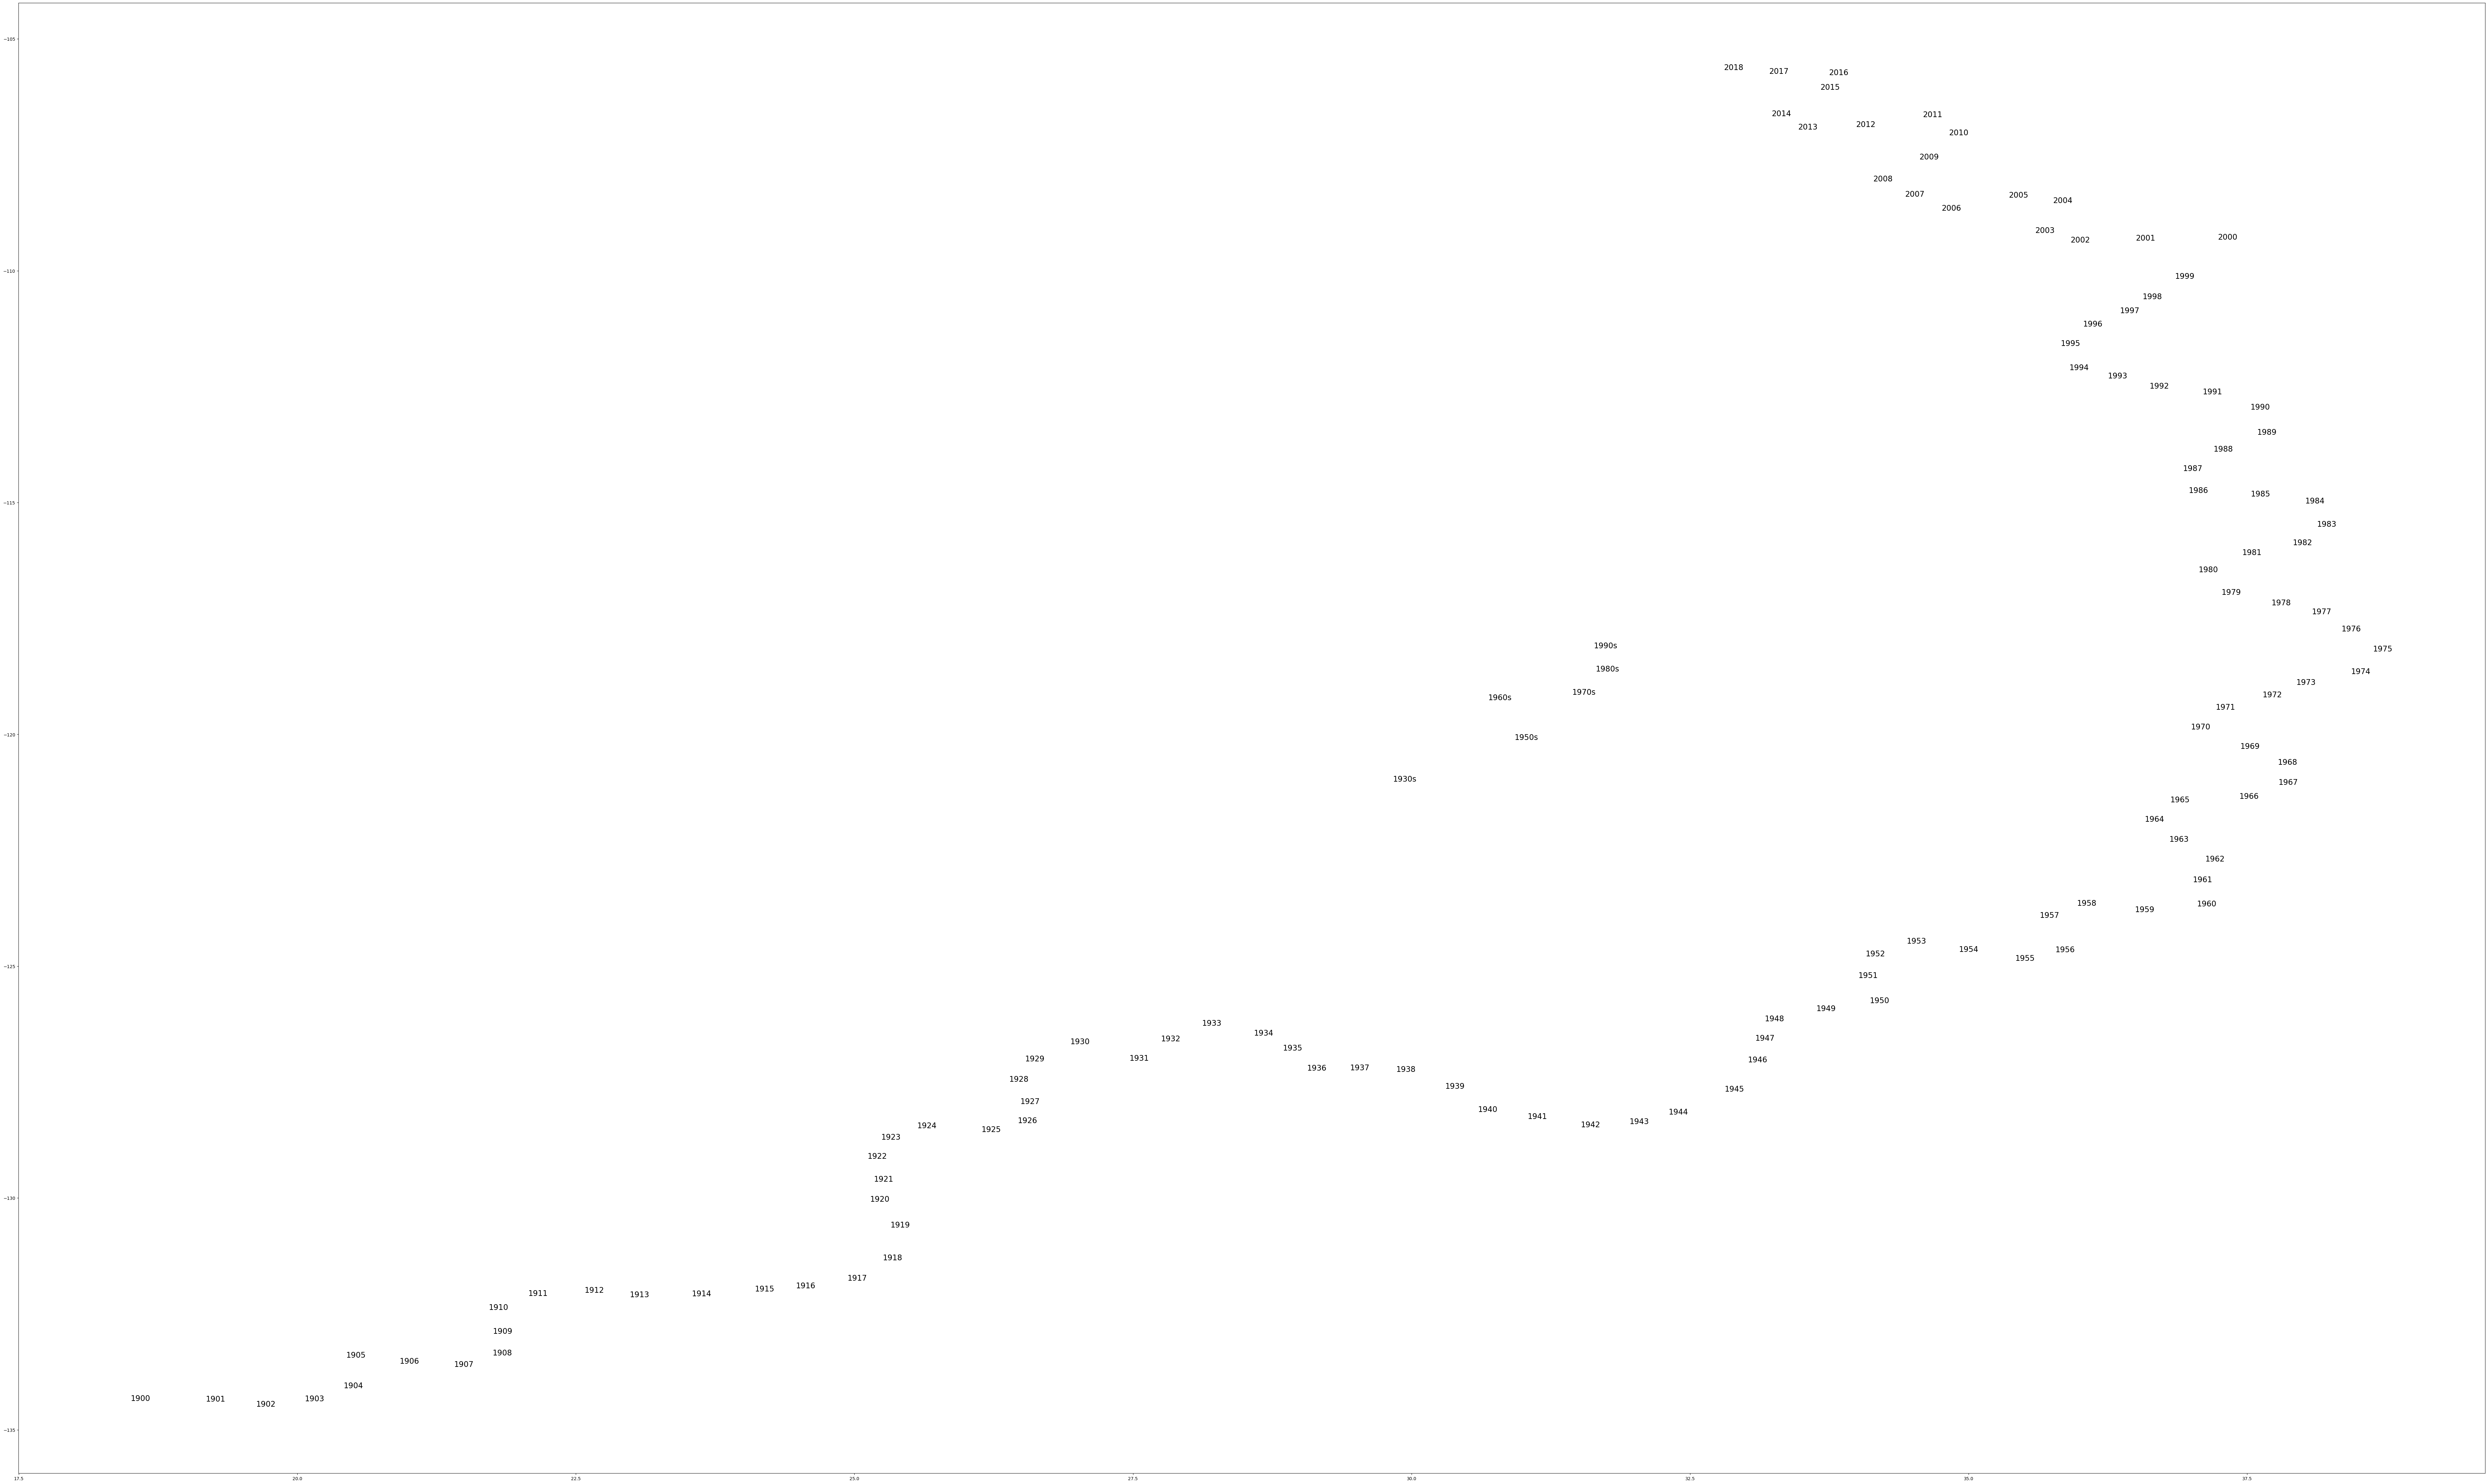

In [16]:
# Plot the transformed BERT vocabulary embeddings:
fig = plt.figure()
alltexts = list()
x_range = (15, 50)
y_range = (-150, -100)


zoomed_mask_x = (bert_word_embs_to_use_tsne[:,0] > x_range[0]) & (bert_word_embs_to_use_tsne[:,0] < x_range[1])
zoomed_mask_y = (bert_word_embs_to_use_tsne[:,1] > y_range[0]) & (bert_word_embs_to_use_tsne[:,1] < y_range[1])

total_mask = zoomed_mask_x & zoomed_mask_y

text = bert_words_to_plot[total_mask[:4000]]
values = (bert_word_embs_to_use_tsne[total_mask])[:text.shape[0]]


for value, txt in zip(values, text):
    plt.scatter(value[0], value[1], s=0)
    currtext = plt.text(value[0], value[1], txt, family='sans-serif', fontsize='xx-large')
    alltexts.append(currtext)
    

# Save the plot before adjusting.
plt.savefig('viz-bert-voc-tsne10k-viz4k-noadj.pdf', format='pdf')

plt.show()

Here's are some close-ups of this projection. The first one has clusters of verbs with similar meanings.

  <img src="Figures/viz-bert-voc-verbs.png" align="center" width=800/> 

Next, we see some sub-word clusters, containing the "##" tag used by BERT's WordPiece tokenization scheme. This cluster consists of English suffixes.

  <img src="Figures/viz-bert-voc-suffixes.png" align="center" width=800/> 

Here is what appears to be a cluster of suffixes of jurisdiction names:

  <img src="Figures/viz-bert-voc-entities.png" align="center" width=800/> 



### Homework

1. **Tokenization** 

Write a generic Python tokenizer, which takes a set of text lines and tabulates the different words (that is, the tokens will be simply English words), keeping track of the frequency of each word.  Use the guidance in the accompanying notebook, 'Homework_1.ipynb'.

2. **Embedding**

Modify the embedding visualization code above to zoom in on various regions of the projections, and identify at least one interesting cluster of tokens.